In [1]:
# Celda 1: Imports básicos

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

In [3]:
# Celda 2: Carga del dataset Online Retail

# Ajusta el nombre si tu archivo se llama distinto
file_path = "Online Retail.xlsx"

df = pd.read_excel(file_path)

print("Dimensiones iniciales:", df.shape)
df.head()


Dimensiones iniciales: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


In [4]:
# Celda 3: Exploración básica

print("Columnas:", df.columns.tolist())
print("\nResumen de datos:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isna().sum())

# Métricas básicas de negocio
# Filtramos transacciones válidas para calcular ingresos (por ejemplo, cantidades positivas)
df_valid = df.copy()
df_valid = df_valid.dropna(subset=["CustomerID"])
df_valid = df_valid[(df_valid["Quantity"] > 0) & (df_valid["UnitPrice"] > 0)]

df_valid["TotalPrice"] = df_valid["Quantity"] * df_valid["UnitPrice"]

num_customers = df_valid["CustomerID"].nunique()
total_revenue = df_valid["TotalPrice"].sum()

print("\nNúmero de clientes únicos:", num_customers)
print("Revenue total:", total_revenue)

df_valid.head()


Columnas: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Resumen de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Valores nulos por columna:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
Custome

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34


In [5]:
# Celda 4: Limpieza adicional (opcional)

# Eliminamos filas sin CustomerID y con montos inválidos (ya se hizo arriba, pero dejamos como paso explícito)
df_clean = df.dropna(subset=["CustomerID"]).copy()
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["UnitPrice"] > 0)]

df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["UnitPrice"]

print("Dimensiones después de la limpieza:", df_clean.shape)
df_clean.head()


Dimensiones después de la limpieza: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom,20.34


In [6]:
# Celda 5: Cálculo de RFM (Recency, Frequency, Monetary)

# Aseguramos que InvoiceDate sea datetime
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"])

# Fecha de referencia (snapshot): un día después de la última compra
snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)

# Agrupamos por CustomerID
rfm = df_clean.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "TotalPrice": "sum"                                       # Monetary
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


Snapshot date: 2011-12-10 12:50:00


,Recency,Frequency,Monetary
CustomerID,,,
"12,346.00",326,1,"77,183.60"
"12,347.00",2,7,"4,310.00"
"12,348.00",75,4,"1,797.24"
"12,349.00",19,1,"1,757.55"
"12,350.00",310,1,334.40


In [7]:
# Celda 6: Exploración de RFM

rfm.describe()


,Recency,Frequency,Monetary
count,"4,338.00","4,338.00","4,338.00"
mean,92.54,4.27,"2,054.27"
std,100.01,7.70,"8,989.23"
min,1.00,1.00,3.75
25%,18.00,1.00,307.41
50%,51.00,2.00,674.49
75%,142.00,5.00,"1,661.74"
max,374.00,209.00,"280,206.02"


In [8]:
# Celda 7: Normalización / escalado de RFM

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Lo convertimos a DataFrame por comodidad
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled_df.head()


,Recency,Frequency,Monetary
CustomerID,,,
"12,346.00",2.33,-0.43,8.36
"12,347.00",-0.91,0.35,0.25
"12,348.00",-0.18,-0.04,-0.03
"12,349.00",-0.74,-0.43,-0.03
"12,350.00",2.17,-0.43,-0.19


In [9]:
# Celda 8: Cálculo de Inertia (Elbow) y Silhouette para distintos k

inertias = []
sil_scores = []
K_range = range(2, 11)  # k de 2 a 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled_df)

    inertias.append(kmeans.inertia_)
    sil = silhouette_score(rfm_scaled_df, labels)
    sil_scores.append(sil)

# Guardamos resultados en un DataFrame opcionalmente
k_results = pd.DataFrame({
    "k": list(K_range),
    "inertia": inertias,
    "silhouette": sil_scores
})
k_results


,k,inertia,silhouette
0,2,"9,012.64",0.90
1,3,"5,439.30",0.59
2,4,"4,092.14",0.62
3,5,"3,118.28",0.62
4,6,"2,472.57",0.60
5,7,"2,022.41",0.52
6,8,"1,742.37",0.52
7,9,"1,445.63",0.48
8,10,"1,303.39",0.43


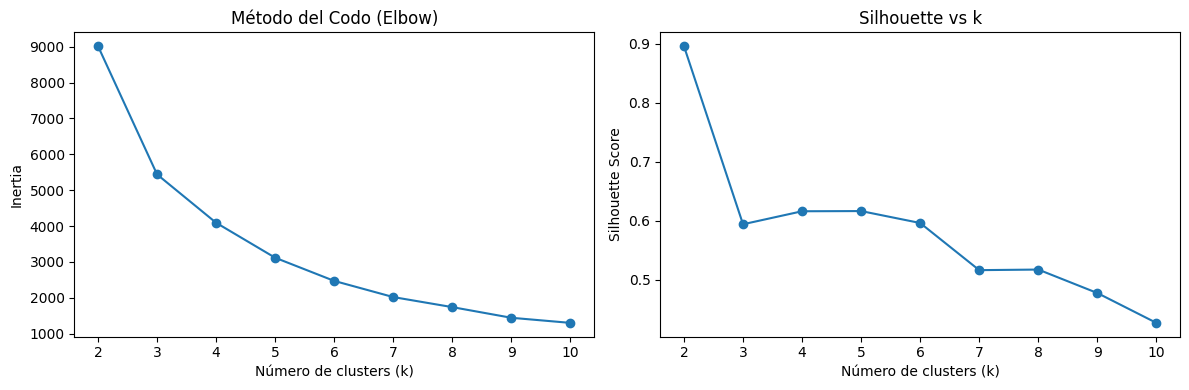

In [10]:
# Celda 9: Gráficas de Elbow (Inertia) y Silhouette

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Elbow
ax[0].plot(list(K_range), inertias, marker="o")
ax[0].set_xlabel("Número de clusters (k)")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Método del Codo (Elbow)")

# Silhouette
ax[1].plot(list(K_range), sil_scores, marker="o")
ax[1].set_xlabel("Número de clusters (k)")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Silhouette vs k")

plt.tight_layout()
plt.show()


In [11]:
# Celda 10: Aplicar K-Means con el número de clusters seleccionado

best_k = 4  # AJUSTA este valor basado en las gráficas anteriores

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
rfm["Cluster_KMeans"] = kmeans_final.fit_predict(rfm_scaled_df)

rfm.head()


,Recency,Frequency,Monetary,Cluster_KMeans
CustomerID,,,,
"12,346.00",326,1,"77,183.60",3
"12,347.00",2,7,"4,310.00",0
"12,348.00",75,4,"1,797.24",0
"12,349.00",19,1,"1,757.55",0
"12,350.00",310,1,334.40,1


In [12]:
# Celda 11: Perfil de clusters (promedio de RFM por cluster)

cluster_profile_kmeans = rfm.groupby("Cluster_KMeans").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Cluster_KMeans": "count"
}).rename(columns={"Cluster_KMeans": "Num_Customers"})

cluster_profile_kmeans


,Recency,Frequency,Monetary,Num_Customers
Cluster_KMeans,,,,
0,43.70,3.68,"1,359.05",3054
1,248.08,1.55,480.62,1067
2,7.38,82.54,"127,338.31",13
3,15.50,22.33,"12,709.09",204


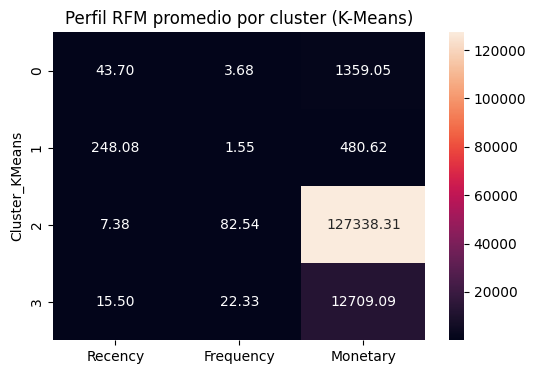

In [13]:
# Celda 12: Heatmap de promedios RFM por cluster

plt.figure(figsize=(6, 4))
sns.heatmap(cluster_profile_kmeans[["Recency", "Frequency", "Monetary"]], annot=True, fmt=".2f")
plt.title("Perfil RFM promedio por cluster (K-Means)")
plt.show()

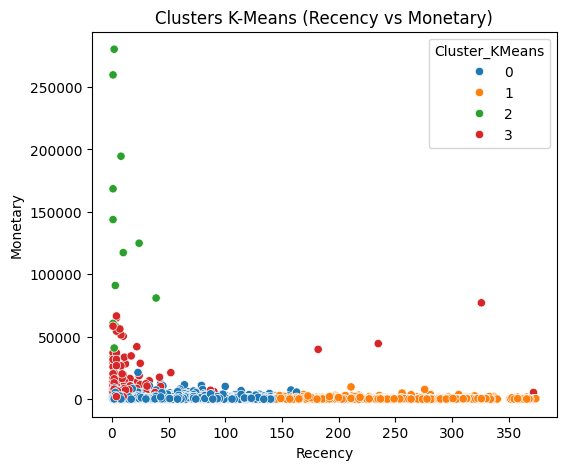

In [14]:
# Celda 13: Visualización 2D de clusters (ejemplo Recency vs Monetary)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="Cluster_KMeans",
    palette="tab10"
)
plt.title("Clusters K-Means (Recency vs Monetary)")
plt.show()


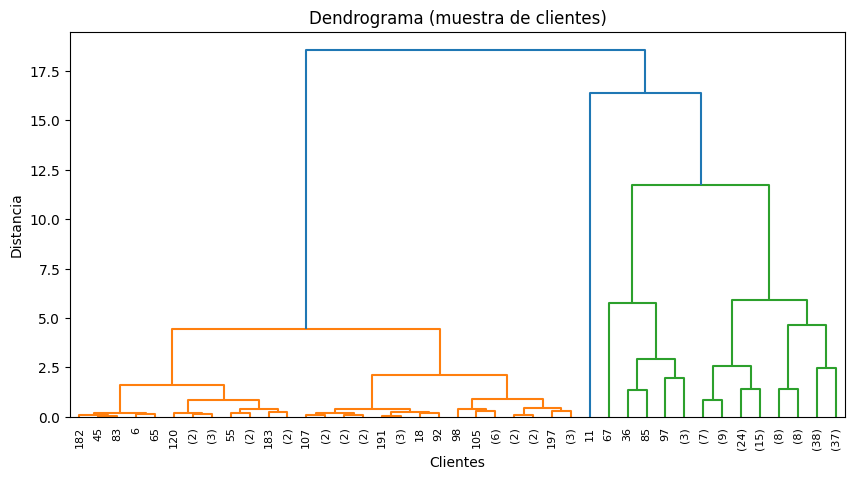

In [15]:
# Celda 14: Dendrograma sobre una muestra de clientes (por rendimiento)

# Tomamos una muestra para el dendrograma
sample_size = 200  # puedes ajustar
rfm_sample = rfm_scaled_df.sample(n=sample_size, random_state=42)

linked = linkage(rfm_sample, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode="level", p=5)
plt.title("Dendrograma (muestra de clientes)")
plt.xlabel("Clientes")
plt.ylabel("Distancia")
plt.show()


In [19]:
# Celda 15: Agglomerative Clustering con el mismo número de clusters best_k

agg_clust = AgglomerativeClustering(
    n_clusters=best_k,
    metric="euclidean",
    linkage="ward"
)

rfm["Cluster_Hier"] = agg_clust.fit_predict(rfm_scaled_df)

rfm.head()

,Recency,Frequency,Monetary,Cluster_KMeans,Cluster_Hier
CustomerID,,,,,
"12,346.00",326,1,"77,183.60",3,0
"12,347.00",2,7,"4,310.00",0,2
"12,348.00",75,4,"1,797.24",0,2
"12,349.00",19,1,"1,757.55",0,2
"12,350.00",310,1,334.40,1,3


In [20]:
# Celda 16: Perfil de clusters jerárquicos

cluster_profile_hier = rfm.groupby("Cluster_Hier").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Cluster_Hier": "count"
}).rename(columns={"Cluster_Hier": "Num_Customers"})

cluster_profile_hier

,Recency,Frequency,Monetary,Num_Customers
Cluster_Hier,,,,
0,24.93,43.79,"31,348.39",56
1,11.00,43.88,"164,658.50",8
2,46.21,4.31,"1,625.46",3325
3,259.54,1.49,457.31,949


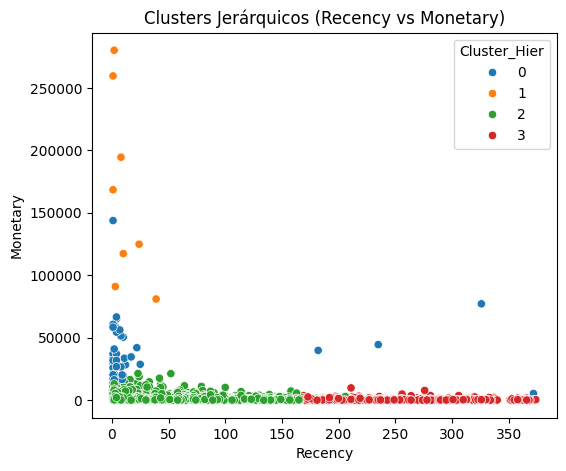

In [21]:
# Celda 17: Visualización 2D para clustering jerárquico

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="Cluster_Hier",
    palette="tab10"
)
plt.title("Clusters Jerárquicos (Recency vs Monetary)")
plt.show()

### Análisis

La segmentación RFM reveló cuatro tipos de clientes claramente diferenciados. La mayoría (Cluster 0, ≈70%) son compradores regulares con gasto y frecuencia moderada, mientras que un 24% pertenece al grupo inactivo (Cluster 1), con *Recency* muy alto y bajo valor económico. Por otro lado, se identificaron dos segmentos clave de alto valor: los clientes VIP (Cluster 2, 13 personas) con gasto extraordinariamente alto y compras muy frecuentes, y un grupo adicional de clientes leales de alto valor (Cluster 3), que mantienen una actividad constante y montos elevados.

Las visualizaciones confirman esta separación: los grupos VIP y leales destacan por su alto *Monetary*, el grupo inactivo se distingue por su *Recency* elevado, y el resto se concentra en valores intermedios. El método jerárquico confirmó la misma estructura general, reforzando la confiabilidad del modelo.

### Conclusión Final

La segmentación demuestra que el negocio depende en gran medida de un grupo muy pequeño de clientes de alto valor, mientras que la mayoría aporta ingresos moderados y un cuarto de la base requiere estrategias de reactivación. En conjunto, estos resultados permiten definir acciones diferenciadas: atención exclusiva para los VIP, programas de fidelización para clientes leales, incentivos para activar a los regulares y campañas específicas para recuperar a los inactivos. Esta clasificación proporciona una base sólida para estrategias de marketing más efectivas y decisiones orientadas a maximizar ingresos.
